#### PIPELINE DO `worflow` de bioinformatica com vias de, atravez de um ficheiro fasta com os aminoacidos codificantes de uma proteina, realizar uma arvore filogenetica(processos de BLASTP, MSA(CLUSTAL), contrução de arvore filogenetica com MATPLOTLIB)

Nota: Apenas uma versão base e passivel de mudanças conforme a necessidade do utilizador, como por exemplo, limitar o nùmero de homologos no ficheiro fasta.

In [2]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import AlignIO
from io import StringIO
import requests
import time
import sys
from Bio import AlignIO
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
import matplotlib.pyplot as plt # Necessário para o desenho gráfico da árvore
from Bio.Align import substitution_matrices # Necessário para matrizes de substituição
from Bio import SeqIO
from Bio.Blast import NCBIWWW, NCBIXML
from Bio import Entrez
from Bio.SeqRecord import SeqRecord
import io # Importar para lidar com dados da NCBIWWW como ficheiro

In [3]:
Entrez.email = "seu.email.aqui@example.com" # <-- !!! MUDAR AQUI !!! Certifique-se que é um email válido!

# Caminho para o seu ficheiro FASTA contendo a única sequência de query.
# Ex: O header no ficheiro pode ser algo como ">myc_query"
input_query_fasta_filepath = "myc_protein.fasta" # <-- !!! MUDAR AQUI !!!

# Quantos resultados de BLAST (hits) únicos (baseado no ID do hit) deseja obter.
# O qblast usa o parâmetro 'alignments', que pode retornar múltiplos alinhamentos para o mesmo hit,
# mas focamo-nos nos IDs únicos dos hits.
num_blast_hits_to_consider = 8 # Quantidade de IDs de hits únicos a considerar do BLAST

# Limite máximo de E-value para os resultados de BLAST
evalue_threshold = 1e-5 # Este valor é importante para filtrar hits significativos

# ID NCBI da sequência de referência que QUER SEMPRE INCLUIR
# Ex: ID da proteína MYC de Mus musculus
reference_protein_id = "NP_034979.3" # MYC isoform a [Mus musculus]

# Nome do ficheiro FASTA onde as sequências resultantes serão salvas
output_fasta_filename = "sequences.fasta" # Nome do ficheiro de saída

## Codigo para o Blastp
Nota: Neste código o `MUS MUSCULUS`, será sempre incluído por ser amplamente usado na area cientifica como termo de estudo e/ou comparação,com isto consideramos interessante inclui-lo na realização desta pipeline


In [4]:


# --- Lógica Principal (Com tratamento de unicidade de sequência) ---

# Lista para armazenar os SeqRecord que serão salvos
all_records_to_save = []
# Conjunto para rastrear sequências (como strings) já adicionadas
seen_sequences = set()
# Conjunto para rastrear IDs que *planeamos* buscar no Entrez, para evitar pedir o mesmo ID múltiplas vezes
ids_to_fetch_planned = set()

try:
    # Lê a sequência de query do ficheiro especificado
    # Assume que o ficheiro tem APENAS UMA sequência
    query_record = list(SeqIO.parse(input_query_fasta_filepath, "fasta"))[0]
    # Adiciona a sequência de query à lista final e ao conjunto de sequências vistas
    all_records_to_save.append(query_record)
    seen_sequences.add(str(query_record.seq))
    print(f"Adicionada sequência de query com ID: {query_record.id}")

    # Executa o BLASTP
    # Usamos um limite superior no alignments para garantir que temos hits suficientes acima do evalue_threshold
    # para depois filtrar
    blast_alignments_limit = num_blast_hits_to_consider * 2 # Pede o dobro para ter margem para filtrar

    print(f"Iniciando busca BLASTp para a sequência {query_record.id}...")
    # Usa io.StringIO para tratar o resultado do NCBIWWW.qblast como um ficheiro na memória
    result_handle = NCBIWWW.qblast(program="blastp",
        database="nr",
        sequence=query_record.seq,
        format_type="XML",
        alignments=blast_alignments_limit,
        expect=evalue_threshold # Adicionado o filtro de evalue diretamente no qblast
        )

    # Lê o resultado XML
    # É importante fechar o handle APÓS LER, mas ANTES de processar grandes resultados
    # Para evitar problemas com a conexão, lê-se para a memória primeiro
    blast_xml_data = result_handle.read()
    result_handle.close()

    # Agora parse o XML a partir dos dados lidos para a memória
    blast_record = NCBIXML.read(io.StringIO(blast_xml_data))
    print("BLAST concluído e resultados lidos.")

    # Coleta IDs dos hits relevantes que ainda não foram vistos E que satisfazem o E-value
    blast_hit_ids_to_fetch = []
    hits_processed_count = 0

    print(f"Processando resultados BLAST (filtrando por E-value <= {evalue_threshold})...")
    # O qblast já filtrou alguns, mas a iteração confirma e limita pelo nosso num_blast_hits_to_consider
    for alignment in blast_record.alignments:
        # Verifica se atingimos o número desejado de hits únicos, excluindo a query
        if hits_processed_count >= num_blast_hits_to_consider:
            break # Para de processar se já temos IDs suficientes

        hit_id = alignment.accession
        # Assume que há sempre pelo menos um HSP com E-value - usar o melhor HSP para o E-value
        best_hsp_evalue = min(hsp.expect for hsp in alignment.hsps)

        # Verifica se:
        # 1. O E-value do melhor HSP está dentro do limite
        # 2. Não é a própria sequência de query (comparando IDs)
        # 3. O ID do hit ainda não foi considerado para busca (evita IDs duplicados na lista a buscar)
        if best_hsp_evalue <= evalue_threshold and \
           hit_id != query_record.id and \
           hit_id not in ids_to_fetch_planned:

            blast_hit_ids_to_fetch.append(hit_id)
            ids_to_fetch_planned.add(hit_id) # Marca como planeado para buscar
            hits_processed_count += 1
            print(f" - Adicionado hit ID {hit_id} (E-value: {best_hsp_evalue:.2e})")
        # else:
        #     print(f" - Hit ID {hit_id} ignorado (E-value {best_hsp_evalue:.2e}, é a query, ou já considerado)") # Opcional para debugging

    # --- Adiciona o ID da sequência de referência obrigatória ---
    # Adiciona APENAS se não for o mesmo ID da query original E se ainda não foi considerado pelos hits
    if reference_protein_id != query_record.id and \
       reference_protein_id not in ids_to_fetch_planned:
        # Adiciona o ID da referência à lista de IDs a buscar (preferencialmente no início)
        blast_hit_ids_to_fetch.insert(0, reference_protein_id)
        ids_to_fetch_planned.add(reference_protein_id) # Marca como planeado
        print(f"Adicionado ID de referência obrigatório: {reference_protein_id}")
    # else:
    #      print(f"ID de referência {reference_protein_id} não adicionado (é a query ou já considerado pelos hits).") # Opcional

    # --- Busca as sequências dos IDs coletados (hits + referência) ---
    ids_to_fetch_string = ",".join(blast_hit_ids_to_fetch)

    # Só faz o fetch com Entrez se houver IDs na lista blast_hit_ids_to_fetch
    if ids_to_fetch_string:
        db_to_fetch = "protein"
        rettype_to_fetch = "fasta"
        retmode_to_fetch = "text"

        print(f"Buscando {len(blast_hit_ids_to_fetch)} sequências via Entrez...")
        fetch_handle = Entrez.efetch(db=db_to_fetch, id=ids_to_fetch_string, rettype=rettype_to_fetch, retmode=retmode_to_fetch)

        # Parse as sequências buscadas
        hit_records = list(SeqIO.parse(fetch_handle, rettype_to_fetch))
        fetch_handle.close()
        print(f"{len(hit_records)} sequências buscadas e prontas para adicionar.")

        # Adiciona as sequências buscadas à lista final APENAS SE A SEQUÊNCIA FOR NOVA
        print("Adicionando sequências buscadas (verificando unicidade)...")
        added_count = 0
        for record in hit_records:
             # Compara a sequência (convertida para string) com as sequências já vistas
            if str(record.seq) not in seen_sequences:
                all_records_to_save.append(record)
                seen_sequences.add(str(record.seq)) # Adiciona a nova sequência vista
                added_count += 1
                print(f" - Adicionada sequência para ID: {record.id}")
            # else:
            #    print(f" - Sequência para ID {record.id} é uma duplicata (baseado na sequência de aminoácidos), ignorada.") # Opcional

        print(f"{added_count} sequências únicas adicionadas dos resultados do BLAST/referência.")

    else:
        print("Nenhum hit significativo ou referência única encontrada para buscar.")


    # Salva todas as sequências (query + hits únicos de sequência + referência única de sequência) num ficheiro FASTA
    print(f"Salvando {len(all_records_to_save)} sequências únicas no ficheiro {output_fasta_filename}...")
    with open(output_fasta_filename, "w") as outfile:
        SeqIO.write(all_records_to_save, outfile, "fasta")

    print("Processo concluído. Ficheiro FASTA gerado.")

except FileNotFoundError:
    print(f"Erro: O ficheiro de query '{input_query_fasta_filepath}' não foi encontrado.")
except IndexError:
    print(f"Erro: O ficheiro de query '{input_query_fasta_filepath}' não contém nenhuma sequência.")
except Exception as e:
    print(f"Ocorreu um erro: {e}")
    print("Por favor, verifique a sua ligação à internet, o email de Entrez, e os IDs fornecidos.")

Adicionada sequência de query com ID: NP_002458.2
Iniciando busca BLASTp para a sequência NP_002458.2...


KeyboardInterrupt: 

## Codigo do MSA com o Clustal

In [5]:
# --- Configuração ---
# Certifique-se de que este ficheiro existe na pasta onde corre o script
fasta_path = "sequences.fasta"
# !!! IMPORTANTE: Substitua pelo seu email ou um email dummy/falso !!!
clustal_email = "afonso.marcos20@gmail.com"
# Define o tipo de sequência (protein ou dna)
sequence_type = "protein" # Mude para "dna" se for o caso


# --- Leitura das sequências ---
sequences = list(SeqIO.parse(fasta_path, "fasta"))

print(f"Carregadas {len(sequences)} sequências.")
# Imprime um preview das sequências lidas (opcional, como no snippet)
for record in sequences:
    print(f"ID: {record.id}")
    # Imprime os primeiros 20 caracteres ou a sequência completa se for curta
    print(f"Seq: {str(record.seq)[:20]} ... (Comprimento: {len(record.seq)})")

# --- Preparação para Clustal Omega ---
# Convertemos a lista de SeqRecord (obtida do ficheiro) para o formato FASTA string
# em memória usando StringIO, que é o que o serviço web espera.
fasta_io = StringIO()
SeqIO.write(sequences, fasta_io, "fasta")
fasta_str = fasta_io.getvalue()

# --- Submissão para Clustal Omega Web Service (EBI) ---
print("\nA submeter sequências para o Clustal Omega no EBI...")
ebi_url = "https://www.ebi.ac.uk/Tools/services/rest/clustalo"

params = {
    "sequence": fasta_str,
    "email": clustal_email,
    "stype": sequence_type, # Usa a variável definida acima
    "outfmt": "clustal" # Formato de saída desejado
}

# Submete o trabalho ao serviço web
response = requests.post(f"{ebi_url}/run", data=params)
job_id = response.text.strip()
print("ID do Trabalho:", job_id)

# --- Espera pela conclusão do trabalho ---

status = "RUNNING"
print("A verificar estado do trabalho...")
while status in ("RUNNING", "PENDING"):
    time.sleep(5) # Espera 5 segundos antes de verificar novamente
    status = requests.get(f"{ebi_url}/status/{job_id}").text.strip()
    # print(f"Estado: {status}...") # Descomente se quiser ver o polling em tempo real

print("Estado Final:", status)

# --- Obtenção e apresentação dos resultados ---
if status == "FINISHED":
    time.sleep(2) # Espera um pouco mais para garantir que o output está disponível
    print("A obter resultados do alinhamento...")
    # Obtém o resultado no formato Clustal
    result = requests.get(f"{ebi_url}/result/{job_id}/aln-clustal").text

    # Carrega o resultado do alinhamento da string para um objeto Biopython Alignment
    aligned_io = StringIO(result)
    alignment = AlignIO.read(aligned_io, "clustal")

    # Apresenta o alinhamento no terminal
    print("\n--- Alinhamento Múltiplo ---")
    print(alignment)
    output_clustal_filename = "clustal_alignment.aln"
    result_clustal_string = requests.get(f"{ebi_url}/result/{job_id}/aln-clustal").text
    try:
        with open(output_clustal_filename, "w") as outfile:
            outfile.write(result_clustal_string)
        print(f"[*] Alinhamento CLUSTAL salvo em '{output_clustal_filename}'.")
    except Exception as e:
        print(f"[!] Erro ao salvar o alinhamento CLUSTAL: {e}",)
        print("[!] O alinhamento não foi salvo no ficheiro.")
else:
    # Se o trabalho não terminou com sucesso, informa o utilizador
    print(f"\nO trabalho de alinhamento falhou ou não terminou (Estado: {status}). Não foi possível obter o resultado.")

print("\n--- Fim do Script ---")

Carregadas 9 sequências.
ID: NP_002458.2
Seq: MDFFRVVENQQPPATMPLNV ... (Comprimento: 454)
ID: NP_034979.3
Seq: MDFLWALETPQTATTMPLNV ... (Comprimento: 454)
ID: BAA01374.2
Seq: MNFFREVENQQPPATMPLNV ... (Comprimento: 454)
ID: sp|P23583.2|MYC_PANTR
Seq: MDFFRIVENQQPPATMPLNV ... (Comprimento: 454)
ID: NP_001341799.1
Seq: MDFFRVVENQPPATMPLNVS ... (Comprimento: 453)
ID: NP_001136266.2
Seq: MDFFRIVENQQPPATMPLNV ... (Comprimento: 454)
ID: PNI85682.1
Seq: LDFFRIVENQQPPATMPLNV ... (Comprimento: 454)
ID: PNI85684.1
Seq: LDFFRIVENQPPATMPLNVS ... (Comprimento: 453)
ID: NP_001422710.1
Seq: MDFFPVVENQQPPATMPLNV ... (Comprimento: 454)

A submeter sequências para o Clustal Omega no EBI...
ID do Trabalho: clustalo-R20250518-091354-0163-86667862-p1m
A verificar estado do trabalho...


KeyboardInterrupt: 

## Construção da árvore filogenetica com `Matplotlib` 

--- A iniciar script de construção de árvore ---
A ler o alinhamento do ficheiro: clustal_alignment.aln (Formato: clustal)...
[*] Alinhamento lido com sucesso: 9 sequências, comprimento 455.

--- Construção da Árvore Filogenética ---
Método de Distância: 'identity'
Método de Construção da Árvore: 'upgma'
Calculando a Matriz de Distância (Identidade)...
Matriz de Distância Calculada:
NP_002458.2 0.000000
NP_034979.3 0.101099    0.000000
BAA01374.2  0.004396    0.103297    0.000000
sp|P23583.2|MYC_PANTR   0.006593    0.098901    0.008791    0.000000
NP_001341799.1  0.002198    0.101099    0.006593    0.008791    0.000000
NP_001136266.2  0.008791    0.101099    0.010989    0.002198    0.010989    0.000000
PNI85682.1  0.010989    0.103297    0.013187    0.004396    0.013187    0.002198    0.000000
PNI85684.1  0.013187    0.103297    0.015385    0.006593    0.010989    0.004396    0.002198    0.000000
NP_001422710.1  0.015385    0.094505    0.019780    0.017582    0.017582    0.019780    0.

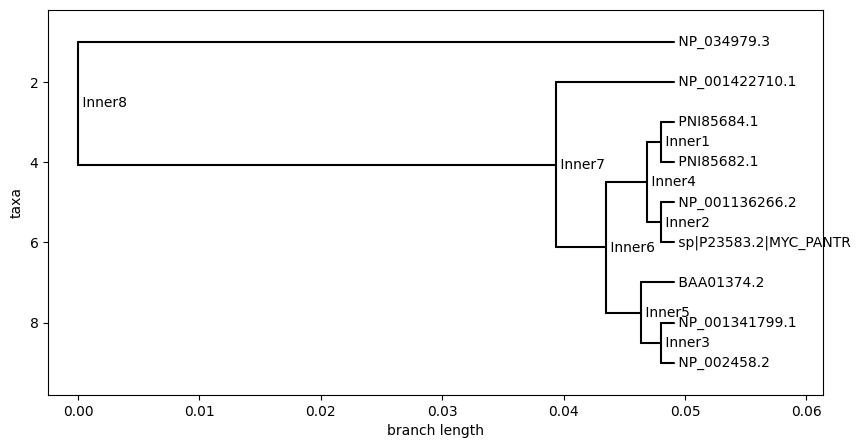

Árvore desenhada. Uma janela gráfica deve ter aparecido.
Feche a janela gráfica para continuar.

Árvore Filogenética (Formato ASCII - terminal):
  ____________________________________________________ NP_034979.3
 |
 |                                           _________ NP_001422710.1
_|                                          |
 |                                          |        , PNI85684.1
 |                                          |       ,|
 |__________________________________________|       || PNI85682.1
                                            |    ___|
                                            |   |   |, NP_001136266.2
                                            |   |   ||
                                            |___|    | sp|P23583.2|MYC_PANTR
                                                |
                                                |   __ BAA01374.2
                                                |__|
                                                   | , NP

In [ ]:
input_alignment_filepath = "clustal_alignment.aln"

# Formato do ficheiro de alinhamento de entrada.
# Ex: 'fasta', 'phylip', 'clustal', 'nexus', 'emboss', etc.
input_alignment_format = "clustal"

# Método para calcular distâncias entre sequências alinhadas.
# 'identity' (fração de diferenças) ou nome de uma matriz de substituição (ex: 'blosum62', 'pam250')
distance_calculation_method = "identity"
# Se as suas sequências forem de PROTEÍNA, 'blosum62' é geralmente mais adequado:
# distance_calculation_method = "blosum62"


# Método para construir a árvore a partir da matriz de distâncias.
# 'upgma' ou 'nj' (Neighbor Joining)
tree_construction_method = "upgma"
# Neighbor Joining é frequentemente preferível a UPGMA:
# tree_construction_method = "nj"


# Nome do ficheiro para salvar a árvore no formato Newick
output_tree_filename = "phylogenetic_tree.nwk"

# --- FIM DAS CONFIGURAÇÕES ---


def read_alignment_file(filepath, format):
    """
    Reads an alignment file and returns the Alignment object.
    """
    print(f"A ler o alinhamento do ficheiro: {filepath} (Formato: {format})...")
    try:
        alignment = AlignIO.read(filepath, format)
        print(f"[*] Alinhamento lido com sucesso: {len(alignment)} sequências, comprimento {alignment.get_alignment_length()}.")
        if not alignment:
             print("[!] Aviso: O ficheiro de alinhamento está vazio.", file=sys.stderr)
             return None
        if len(alignment) < 2:
             print("[!] Aviso: São necessárias pelo menos 2 sequências no alinhamento para construir uma árvore filogenética.", file=sys.stderr)
             return None
        if alignment.get_alignment_length() == 0:
             print("[!] Aviso: O alinhamento tem comprimento zero.", file=sys.stderr)
             return None

        return alignment

    except FileNotFoundError:
        print(f"[!] ERRO: Ficheiro de alinhamento não encontrado em {filepath}", file=sys.stderr)
        return None
    except ValueError as e:
         print(f"[!] ERRO ao ler o ficheiro '{filepath}': {e}", file=sys.stderr)
         print(f"    Verifique se o ficheiro está realmente no formato '{format}'.", file=sys.stderr)
         return None
    except Exception as e:
         print(f"[!] ERRO inesperado ao ler o ficheiro de alinhamento: {e}", file=sys.stderr)
         return None


def build_and_draw_tree(alignment, distance_method, tree_method, output_tree_file):
    """
    Calculates distances, builds the tree, draws it, and saves it.
    """
    print("\n--- Construção da Árvore Filogenética ---")
    print(f"Método de Distância: '{distance_method}'")
    print(f"Método de Construção da Árvore: '{tree_method}'")


    # 1. Calcular a Matriz de Distância
    try:
        if distance_method == 'identity':
             calculator = DistanceCalculator('identity')
             print("Calculando a Matriz de Distância (Identidade)...")
        else: # Assume que é um nome de matriz de substituição
             try:
                matrix = substitution_matrices.load(distance_method)
                calculator = DistanceCalculator(matrix)
                print(f"Calculando a Matriz de Distância (Matriz de Substituição: {distance_method})...")
             except Exception as matrix_error:
                 print(f"[!] ERRO ao carregar a matriz de substituição '{distance_method}': {matrix_error}", file=sys.stderr)
                 print("    Cálculo da matriz de distância falhou.", file=sys.stderr)
                 return
        
        dm = calculator.get_distance(alignment)
        print("Matriz de Distância Calculada:")
        print(dm) # Imprime a matriz no terminal
    except Exception as e:
        print(f"[!] ERRO ao calcular a matriz de distância: {e}", file=sys.stderr)
        return


    # 2. Construir a Árvore
    try:
        constructor = DistanceTreeConstructor() # Construtor padrão

        if tree_method == "upgma":
             print(f"\nConstruindo a Árvore Filogenética (Método UPGMA)...")
             tree = constructor.upgma(dm)
        elif tree_method == "nj":
             print(f"\nConstruindo a Árvore Filogenética (Método Neighbor Joining)...")
             tree = constructor.nj(dm)
        else:
             print(f"[!] Método de construção da árvore desconhecido nas configurações: '{tree_method}'. Use 'upgma' ou 'nj'.", file=sys.stderr)
             return

        print("Árvore construída com sucesso.")
    except Exception as e:
        print(f"[!] ERRO ao construir a árvore: {e}", file=sys.stderr)
        return

    # 3. Desenhar a Árvore (Gráfica)
    try:
        print("\nTentando desenhar a árvore graficamente (requer matplotlib)...")
        # Cria a figura e os eixos
        # O tamanho da figura pode ser ajustado
        fig = plt.figure(figsize=(10, max(5, len(alignment)*0.5))) # Ajusta altura baseada no nº de seqs
        axes = fig.add_subplot(1, 1, 1)

        # Desenha a árvore nos eixos criados
        Phylo.draw(tree, axes=axes)

        print("Árvore desenhada. Uma janela gráfica deve ter aparecido.")
        # Mostra a janela gráfica. Em muitos editores, esta linha é necessária.
        plt.show()
        print("Feche a janela gráfica para continuar.")

    except ImportError:
        print("[!] Ignorando o desenho gráfico: A biblioteca 'matplotlib' não está instalada.")
        print("    Para desenhar a árvore graficamente, instale-a com: pip install matplotlib")
    except Exception as e:
         print(f"[!] ERRO ao desenhar a árvore graficamente: {e}", file=sys.stderr)


    # 4. Desenhar a Árvore (ASCII no Terminal)
    print("\nÁrvore Filogenética (Formato ASCII - terminal):")
    try:
        Phylo.draw_ascii(tree)
    except Exception as e:
        print(f"[!] ERRO ao desenhar a árvore em ASCII: {e}", file=sys.stderr)

    # 5. Salvar a árvore num ficheiro (formato Newick)
    print(f"\nSalvando a árvore no formato Newick em '{output_tree_file}'...")
    try:
        Phylo.write(tree, output_tree_file, "newick")
        print(f"[*] Árvore salva com sucesso em '{output_tree_file}'.")
        print("    Este ficheiro pode ser aberto em visualizadores de árvores filogenéticas (ex: FigTree, iTOL).")
    except Exception as e:
         print(f"[!] ERRO ao salvar a árvore: {e}", file=sys.stderr)


# --- Execução Principal ---
def main():
    # As configurações são lidas das variáveis no início do script
    print("--- A iniciar script de construção de árvore ---")

# --- FIM DAS CONFIGURAÇÕES ---
    # Lê o alinhamento do ficheiro especificado nas configurações
    alignment = read_alignment_file(input_alignment_filepath, input_alignment_format)

    # Se a leitura foi bem sucedida, constrói e desenha/salva a árvore
    if alignment:
        build_and_draw_tree(alignment, distance_calculation_method, tree_construction_method, output_tree_filename)
    else:
        print("\n[!] Script terminado devido a erro na leitura do alinhamento.", file=sys.stderr)
        # Não saímos com sys.exit(1) se estamos a correr no editor,
        # para não fechar a consola imediatamente.

if __name__ == "__main__":
    main()


Descoberta de motifs

In [10]:
#!/usr/bin/env python3

# Remover import argparse
# import argparse
from Bio import SeqIO
from collections import defaultdict
import os # Importar o módulo os para verificar a existência do ficheiro

def find_frequent_kmers(fasta_file, k, min_frequency):
    """
    Lê sequências de um ficheiro FASTA e encontra k-mers que ocorrem
    com uma frequência mínima especificada.

    Args:
        fasta_file (str): Caminho para o ficheiro FASTA de entrada.
        k (int): O comprimento do k-mer a procurar.
        min_frequency (int): A frequência mínima para um k-mer ser
                             considerado um motif.

    Returns:
        dict: Um dicionário onde as chaves são os k-mers frequentes e
              os valores são dicionários contendo a contagem ('count')
              e uma lista de localizações ('locations') no formato
              (id_sequencia, posição_inicial).
        int: O número total de k-mers de comprimento k que foram escaneados.
    """
    kmer_counts = defaultdict(int)
    kmer_locations = defaultdict(list)
    total_kmers_scanned = 0

    # Adicionar verificação explícita se o ficheiro existe
    if not os.path.exists(fasta_file):
        print(f"Erro: O ficheiro '{fasta_file}' não foi encontrado.")
        return {}, 0

    try:
        print(f"A ler sequências do ficheiro: {fasta_file}")
        records = list(SeqIO.parse(fasta_file, "fasta"))
        if not records:
            print(f"Aviso: Nenhuma sequência encontrada no ficheiro FASTA '{fasta_file}' ou o formato não é FASTA válido.")
            return {}, 0

        print(f"Encontradas {len(records)} sequências.")

        for record in records:
            sequence = str(record.seq).upper() # Converter para string e maiúsculas
            seq_id = record.id

            if len(sequence) < k:
                # print(f"Aviso: A sequência '{seq_id}' ({len(sequence)} bp) é mais curta que k={k}. Ignorada.") # Comentado para evitar muita saída
                continue

            for i in range(len(sequence) - k + 1):
                kmer = sequence[i : i + k]
                # Opcional: Ignorar k-mers com 'N' se for DNA e quiser apenas bases canónicas
                # if 'N' in kmer:
                #     continue
                kmer_counts[kmer] += 1
                kmer_locations[kmer].append((seq_id, i))
                total_kmers_scanned += 1

    except Exception as e:
        print(f"Ocorreu um erro ao ler ou processar o ficheiro FASTA '{fasta_file}': {e}")
        return {}, 0

    frequent_motifs = {}
    for kmer, count in kmer_counts.items():
        if count >= min_frequency:
            frequent_motifs[kmer] = {
                'count': count,
                'locations': kmer_locations[kmer]
            }

    return frequent_motifs, total_kmers_scanned

def report_motifs(frequent_motifs, total_kmers_scanned, k, min_frequency, fasta_file):
    """
    Imprime um relatório dos k-mers frequentes encontrados.

    Args:
        frequent_motifs (dict): Dicionário com os motifs frequentes e os seus dados.
        total_kmers_scanned (int): O número total de k-mers escaneados.
        k (int): O comprimento do k-mer.
        min_frequency (int): A frequência mínima usada no filtro.
        fasta_file (str): O nome do ficheiro FASTA analisado.
    """
    print("\n--- Resultados da Descoberta de Motifs ---")
    print(f"Ficheiro Analisado: {fasta_file}")
    print(f"Parâmetros: k={k}, Frequência Mínima={min_frequency}")
    print(f"Total de k-mers de comprimento {k} escaneados: {total_kmers_scanned}")
    print(f"Encontrados {len(frequent_motifs)} k-mers que cumprem os critérios.")

    if not frequent_motifs:
        print("\nNão foram encontrados motifs frequentes com os critérios especificados.")
        return

    # Ordenar os motifs por frequência (do mais frequente para o menos)
    sorted_motifs = sorted(frequent_motifs.items(), key=lambda item: item[1]['count'], reverse=True)

    print("\nMotifs Frequentes (Ordenados por Frequência):")
    print("------------------------------------------")
    for kmer, data in sorted_motifs:
        count = data['count']
        locations = data['locations']
        print(f"Motif: {kmer}")
        print(f"  Contagem: {count}")
        print(f"  Localizações ({len(locations)} ocorrências):")
        # Imprimir um número limitado de localizações para não sobrecarregar a saída
        display_limit = 10
        for i, (seq_id, start_pos) in enumerate(locations):
            if i < display_limit:
                print(f"    - Seq '{seq_id}' na posição {start_pos}")
            elif i == display_limit:
                print(f"    ... e mais {len(locations) - display_limit} localizações.")
                break # Parar de imprimir localizações depois do limite

        print("-" * 20) # Separador entre motifs

    print("\n--- Fim dos Resultados ---")


if __name__ == "__main__":
    # --- DEFINIR OS PARÂMETROS AQUI ---
    # Nome do ficheiro FASTA a analisar
    input_fasta_file = "sequences.fasta"

    # O comprimento do k-mer (motif) a procurar
    kmer_length = 8

    # A frequência mínima (número de ocorrências) para um k-mer ser considerado um motif
    minimum_frequency = 3
    # ---------------------------------


    # Validar inputs (opcional, mas boa prática)
    if kmer_length <= 0:
        print("Erro: O comprimento do k-mer (kmer_length) deve ser um número inteiro positivo.")
        exit(1)
    if minimum_frequency <= 0:
         print("Erro: A frequência mínima (minimum_frequency) deve ser um número inteiro positivo.")
         exit(1)

    # Chamar as funções principais com os parâmetros definidos
    frequent_motifs, total_scanned = find_frequent_kmers(
        input_fasta_file, kmer_length, minimum_frequency
    )

    # Gerar o relatório (apenas se o ficheiro foi lido com sucesso)
    if frequent_motifs is not None or total_scanned > 0: # Verificar se find_frequent_kmers não retornou erro de ficheiro
         report_motifs(
             frequent_motifs, total_scanned, kmer_length, minimum_frequency, input_fasta_file
         )

A ler sequências do ficheiro: sequences.fasta
Encontradas 9 sequências.

--- Resultados da Descoberta de Motifs ---
Ficheiro Analisado: sequences.fasta
Parâmetros: k=8, Frequência Mínima=3
Total de k-mers de comprimento 8 escaneados: 4021
Encontrados 469 k-mers que cumprem os critérios.

Motifs Frequentes (Ordenados por Frequência):
------------------------------------------
Motif: FTNRNYDL
  Contagem: 9
  Localizações (9 ocorrências):
    - Seq 'NP_002458.2' na posição 21
    - Seq 'NP_034979.3' na posição 21
    - Seq 'BAA01374.2' na posição 21
    - Seq 'sp|P23583.2|MYC_PANTR' na posição 21
    - Seq 'NP_001341799.1' na posição 20
    - Seq 'NP_001136266.2' na posição 21
    - Seq 'PNI85682.1' na posição 21
    - Seq 'PNI85684.1' na posição 20
    - Seq 'NP_001422710.1' na posição 21
--------------------
Motif: TNRNYDLD
  Contagem: 9
  Localizações (9 ocorrências):
    - Seq 'NP_002458.2' na posição 22
    - Seq 'NP_034979.3' na posição 22
    - Seq 'BAA01374.2' na posição 22
    - 